# Master data analysis
## Import data
Import the data of master students from 2007. Those data are storaged in a dict.

In [1]:
import pandas as pd
import numpy as np
import glob as gl
from ISA_api import get_all_student_list

# Use ISA_api to crawl all the master data from 2007
ms_students = get_all_student_list('master')

In [2]:
ms_students['Informatique, 2007-2008, Master semestre 1'][0]

{'gender': 'Monsieur',
 'minor': '',
 'name': 'Aeberhard François-Xavier',
 'sciper': '153066',
 'specialization': '',
 'status': 'Présent'}

## Obtain master student information dataframe
This part converts dictionary 'ms_students' to a dataframe.

Each row of the dataframe represents a record (one semester) of one student.
The column of the dataframe is respectively = ['name','gender','year','master_type','sciper','specialization','minor','status'].

Since our analysis focus on students who finish their full time of study between 2007-2016, the edge students, namely students who study in 2007-2008 but not as a fresh student, and students who study in 2016-2017 as a fresh student should not be considered, and thus should not be added to dataframe.


In [3]:
master = []
# iterate dictionary to construct an information dataframe.
for semester,info in ms_students.items():
    #Dataframe for current iterating semester.
    df = pd.DataFrame(info)
    #split keys into features of faculty, year, master_type
    _, year, master_type = semester.split(', ')
    #add feature master_type and year to dataframe
    df['master_type'] = master_type
    df['year'] = year
    #Deal with data in border
    #For data in 2007-2008, only append those who begin their study at that year.
    if (year == '2007-2008' and ):
        if (master_type in ['Master semestre 1','Master semestre 2']):
            master.append(df)
    #For data in 2016-2017, only append those who do not begin their study at that year.
    elif (year == '2016-2017'):
        if (master_type not in ['Master semestre 1']):
            master.append(df)
    else :
        master.append(df)
masterDf = pd.concat(master)
# Reindex column and sort dataframe
masterDf = masterDf[['name','gender','year','master_type','sciper','specialization','minor','status']]
masterDf = masterDf.sort_values(by = ['year','name','master_type'])
masterDf.head()

,name,gender,year,master_type,sciper,specialization,minor,status
0,Aeberhard François-Xavier,Monsieur,2007-2008,Master semestre 1,153066,,,Présent
0,Aeberhard François-Xavier,Monsieur,2007-2008,Master semestre 2,153066,,,Présent
1,Agarwal Megha,Madame,2007-2008,Master semestre 1,180027,,,Présent
1,Agarwal Megha,Madame,2007-2008,Master semestre 2,180027,,,Présent
2,Anagnostaras David,Monsieur,2007-2008,Master semestre 1,152232,,,Présent


## Average stay computation rules and algorithm
Compute average stay for EPFL IN master students using data above.
Due to the huge mess of master data, after observing data itself and asking senior students for the real cases,
we assume some rules below to calculate the stay time of one student:

1. Concerns with 'Admission automne': If a student starts with master semester 2, but does not appear in 2007-2008, that might be because there is a admission automn semester before MA2 (and this is mostly the case with abnormal data in 2015-2016), so we manually add one semester to MA1. But if this happens in 2007-2008, this might due to the data reaches one of its borders, and in this case we just remove these students from valid dataset.

2. Concerns with students who didn't finish their studies: After applying first rule, if the record of a student is still smaller than 2, then either his missing rate is high or he didn't finish study at all. Then we just remove these students from valid dataset.

3. Concerns with 'Project master': Most students in ISA didn't show in project master semester due to missing data. To evaluate their stay time, we need to manually add one semester for:
    * Students whose last semesters are before 2015-2016 without project semester;
    * Students whose last semesters are in 2015-2016 or 2016-2017 and their stay time are more that 2 semesters; but if their stay time are fewer than 2 semesters, we are not sure about what he/she is doing this semester and we remove them from valid dataset.

4. After applying rule 1,2,3 to master data, if the number of semester >= 3 semester, then we consider this data record to be a complete study process, otherwise we don't include it in the data used to calculate average stay.

In [14]:
# Calculate the time a master student spent to graduate.
# Define studyTime dataframe to record the stay time and matriculation year of a student.
studyTime = pd.DataFrame()
groupedByName = masterDf.groupby(['name'])
for name,info in groupedByName:
    info = info.sort_values(by = ['year','master_type'])
    #Record number of semester stay
    time_sem = len(info)
   
    # Rule 1 : Concerns with 'Admission automne'
    if ((info.iloc[0].master_type == ('Master semestre 2')) & (info.iloc[0].year != '2007-2008')) :
        time_sem += 1

    #Store the matriculation year for bonus task.
    matriYear = info.iloc[0].year
    #Rule 2: Concerns with students who didn't finish study
    if (time_sem >= 2):
        #Rule 3: Concerns with 'Project master'
        if (info.iloc[-1].master_type not in ['Projet Master automne','Projet Master printemps']):
            if info.iloc[-1].year == '2015-2016':
                if (time_sem != 2):
                    time_sem += 1
            else:
                if info.iloc[-1].year != '2016-2017':
                    time_sem += 1
                else :
                    time_sem = -1
    #Rule 4 : Record only those who spent more than 3 semester in EPFL
    if (time_sem >= 3):
        time_month = time_sem * 6
        studyTime = studyTime.append({'name':name,'time':time_month,'matriculation year':matriYear},ignore_index=True)
studyTime = studyTime[['name','time','matriculation year']].sort_values(by = ['matriculation year','name'])
studyTime.head()

,name,time,matriculation year
2,Aeberhard François-Xavier,42.0,2007-2008
3,Agarwal Megha,18.0,2007-2008
8,Anagnostaras David,24.0,2007-2008
23,Auroux Damien,24.0,2007-2008
24,Awalebo Joseph,24.0,2007-2008


## Task 1: Compute average stay of EPFL IN masster students.

Use describe function to see statistics attributes of studyTime dataFrame.
And find the average stay of EPFL IN master student after 2007 is 25.6 month.


In [15]:
studyTime.describe()

,time
count,640.000000
mean,25.603125
std,5.954338
min,18.000000
25%,24.000000
50%,24.000000
75%,30.000000
max,48.000000


Join timeinfo dataframe to the master studet dataframe we get at first.

In [6]:
masterDfWithTime = pd.merge(masterDf,studyTime)
masterDfWithTime.head()

,name,gender,year,master_type,sciper,specialization,minor,status,time,matriculation year
0,Aeberhard François-Xavier,Monsieur,2007-2008,Master semestre 1,153066,,,Présent,42.0,2007-2008
1,Aeberhard François-Xavier,Monsieur,2007-2008,Master semestre 2,153066,,,Présent,42.0,2007-2008
2,Aeberhard François-Xavier,Monsieur,2008-2009,Master semestre 2,153066,,,Stage,42.0,2007-2008
3,Aeberhard François-Xavier,Monsieur,2008-2009,Master semestre 3,153066,,,Présent,42.0,2007-2008
4,Aeberhard François-Xavier,Monsieur,2009-2010,Master semestre 2,153066,Internet computing,,Présent,42.0,2007-2008


## Task 2 Gender based analysis.

Calculate average stays by gender and test the significance of difference between them.

Here, since the female student data and male student data can be seen as two unpaired sample with unequal size and unequal variance, we should use welch t test for our hypothesis test. 

**Our null hypothesis is their average time has no significant difference. **

               time
gender             
Madame    25.704545
Monsieur  25.586957
The difference between the mean graduation time of female and male is not significant


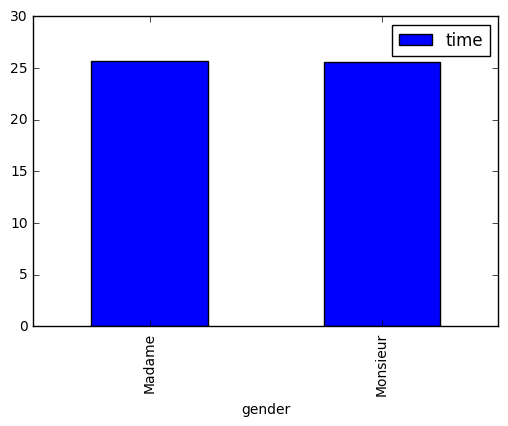

In [7]:
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt

# Select name,gender and time row from original dataframe and drop the duplicate information.
dfGender = masterDfWithTime[['name','gender','time']]
dfGender = dfGender.drop_duplicates()
# Group data by gender.
groupByGender = dfGender.groupby(['gender'])
# Calculae average stay by gender group
print(groupByGender.apply(np.mean))
groupByGender.apply(np.mean).plot.bar()
# Apply welch t test to two groups.
t, p = stats.ttest_ind(groupByGender.get_group('Monsieur').time,groupByGender.get_group('Madame').time,equal_var=False,)

if (p < 0.05):
    print('The difference between the mean graduation time of female and male is significant')
else:
    print('The difference between the mean graduation time of female and male is not significant')

## Task 3: Specilization based analysis

Apply same analysis to different specializations. Calculate the average stay of students with different specializations.

To measure the differences between average stay of each specialization category and average stay of all  specializations, we should do a single-sample t test to each specialization group respectively.

Average stay of students with specialization is 28.83076923076923 months
                                     time      
                                     mean count
specialization                                 
Biocomputing                    30.000000     4
Computer Engineering - SP       26.571429    14
Foundations of Software         28.867925    53
Information Security - SP       30.000000     2
Internet computing              28.609756    82
Service science                 27.600000     5
Signals, Images and Interfaces  30.960000    25
Software Systems                28.200000    10
Average stay of Computer Engineering - SP students is significantly different
Average stay of Information Security - SP students is significantly different


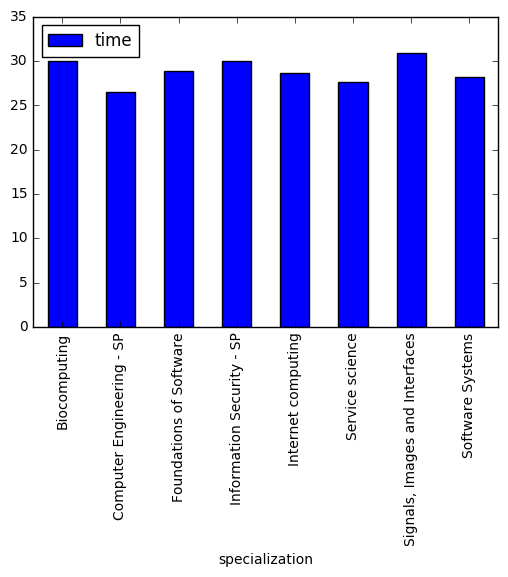

In [8]:
# Select name,gender and time row from original dataframe.
# Drop the student withou specialization and also drop the duplicate information.
dfSpeci = masterDfWithTime[['name','specialization','time']]
dfSpeci = dfSpeci[dfSpeci.specialization != '']
dfSpeci = dfSpeci.drop_duplicates()
# Calculate the average stay of all students with specialization
meanAllSpeci = dfSpeci.time.mean()
print('Average stay of students with specialization is ' + str(meanAllSpeci) + ' months')
# Group student by specialization
speciGroup = dfSpeci.groupby('specialization')
# Count numbers in each group and calcualte average time, plot the bar.
print(speciGroup.agg(['mean','count']))
speciGroup.apply(np.mean).plot.bar()
# Apply 1-sample t test for each group.
for speci,timeInfo in speciGroup:
    t, p = stats.ttest_1samp(timeInfo.time,meanAllSpeci)
    if (p < 0.05):
        print('Average stay of ' + speci + ' students is significantly different')

### Abnormal phenomena explanation:

From results above, it can be seen that although speicialization 'information security - sp' doesn't have higher average stay compared to others, it is labeled as signicantly difference due to small sample. Therefore, it only makes sense when the sample size reach certain number.

## Task 4  Plot the trends of result over time

Use scatterplots to visually identify changes over time. Plot males and females with different colors -- can you spot different trends that match the results of your statistical tests?

Since pandas can only plot scatter chart with two numerical columns, we add one int column, year, to indicate a student's matriculation year. Then we plot all students' stay time in a scatter chart, with male students being blue dots and female students red dots.

(2006, 2016)

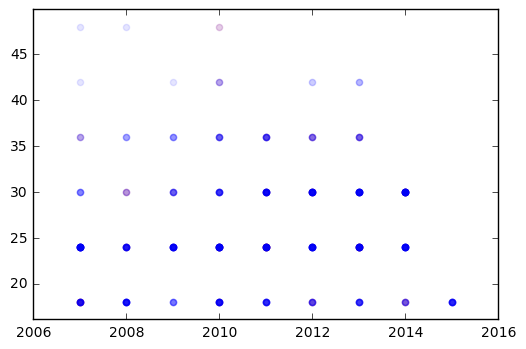

In [141]:
dfGenderMatri = masterDfWithTime[['name','gender','time','matriculation year']].drop_duplicates()
dfGenderMatri['year'] = dfGenderMatri['matriculation year'].apply(lambda x: x.split('-')[0]).astype('int')

fig, ax = plt.subplots()
ax.margins(0.05)
COLOR = {'Monsieur': 'blue', 'Madame': 'red'}
for name, group in dfGenderMatri.groupby('gender'):
    ax.scatter(x=group.year, y=group.time, color=COLOR[name], alpha=0.1)
plt.xlim(xmin=2006, xmax=2016)

Although we add some opacity to our colors, which illustrates that darker color indicates more people are at the same coordinate, this chart isn't intuitive at all for the fact that too many students' data points overlap. (Purple dots are generated due to overlap between red and blue.) So we consider to draw another scatter chart of average stays between females and males.

(2006, 2016)

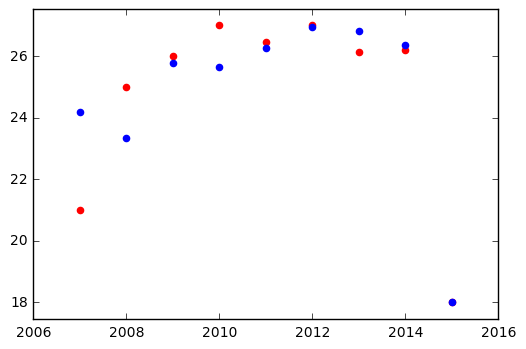

In [142]:
mean_groups = dfGenderMatri.groupby(['gender', 'matriculation year']).agg({'time': 'mean'})
re_mean_groups = mean_groups.reset_index()
re_mean_groups['year'] = re_mean_groups['matriculation year'].apply(lambda x: x.split('-')[0]).astype('int')

fig, ax = plt.subplots()
ax.margins(0.05)
COLOR = {'Monsieur': 'blue', 'Madame': 'red'}
for name, group in re_mean_groups.groupby('gender'):
    ax.scatter(x=group.year, y=group.time, color=COLOR[name])
plt.xlim(xmin=2006, xmax=2016)

We can ituitively tell from the scatter chart that the differences between females and males are not that significant, except for year 2007 and 2008. However, as described in task 1, there's no significant difference if the data of year 2007 and 2008 are blended with all other data.